## PyTorch/XLA ResNet18/CIFAR10 (GPU or TPU)

### [RUNME] Install Colab compatible PyTorch/XLA wheels and dependencies



In [ ]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8.1-cp37-cp37m-linux_x86_64.whl

     |████████████████████████████████| 145.0MB 29kB/s 
     |████████████████████████████████| 61kB 2.9MB/s 
ERROR: earthengine-api 0.1.269 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.8.0 which is incompatible.
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8


Only run the below commented cell if you would like a nightly release

In [ ]:
# VERSION = "nightly"  #@param ["nightly", "20200516"]  # or YYYYMMDD format
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION
# import os 
# os.environ['LD_LIBRARY_PATH']='/usr/local/lib'
# !echo $LD_LIBRARY_PATH

# !sudo ln -s /usr/local/lib/libmkl_intel_lp64.so /usr/local/lib/libmkl_intel_lp64.so.1
# !sudo ln -s /usr/local/lib/libmkl_intel_thread.so /usr/local/lib/libmkl_intel_thread.so.1
# !sudo ln -s /usr/local/lib/libmkl_core.so /usr/local/lib/libmkl_core.so.1

# !ldconfig
# !ldd /usr/local/lib/python3.7/dist-packages/torch/lib/libtorch.so

In [ ]:
# PyTorch/XLA GPU Setup (only if GPU runtime)
import os
if os.environ.get('COLAB_GPU', '0') == '1':
  os.environ['GPU_NUM_DEVICES'] = '1'
  os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda/'

### Define Parameters



In [ ]:
# Result Visualization Helper
from matplotlib import pyplot as plt

M, N = 4, 6
RESULT_IMG_PATH = '/tmp/test_result.jpg'
CIFAR10_LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_results(images, labels, preds):
  images, labels, preds = images[:M*N], labels[:M*N], preds[:M*N]
  inv_norm = transforms.Normalize(
      mean=(-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010),
      std=(1/0.2023, 1/0.1994, 1/0.2010))

  num_images = images.shape[0]
  fig, axes = plt.subplots(M, N, figsize=(16, 9))
  fig.suptitle('Correct / Predicted Labels (Red text for incorrect ones)')

  for i, ax in enumerate(fig.axes):
    ax.axis('off')
    if i >= num_images:
      continue
    img, label, prediction = images[i], labels[i], preds[i]
    img = inv_norm(img)
    img = img.permute(1, 2, 0) # (C, M, N) -> (M, N, C)
    label, prediction = label.item(), prediction.item()
    if label == prediction:
      ax.set_title(u'\u2713', color='blue', fontsize=22)
    else:
      ax.set_title(
          'X {}/{}'.format(CIFAR10_LABELS[label],
                          CIFAR10_LABELS[prediction]), color='red')
    ax.imshow(img)
  plt.savefig(RESULT_IMG_PATH, transparent=True)

In [ ]:
# Define Parameters
FLAGS = {}
FLAGS['data_dir'] = "/tmp/cifar"
FLAGS['batch_size'] = 128
FLAGS['num_workers'] = 4
FLAGS['learning_rate'] = 0.02
FLAGS['momentum'] = 0.9
FLAGS['num_epochs'] = 20
FLAGS['num_cores'] = 8 if os.environ.get('TPU_NAME', None) else 1
FLAGS['log_steps'] = 20
FLAGS['metrics_debug'] = False

In [ ]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_xla
import torch_xla.core.xla_model as xm
import torch_xla.debug.metrics as met
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp
import torch_xla.utils.utils as xu
import torchvision
from torchvision import datasets, transforms

class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_planes, planes, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(
        in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(
        planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.shortcut = nn.Sequential()
    if stride != 1 or in_planes != self.expansion * planes:
      self.shortcut = nn.Sequential(
          nn.Conv2d(
              in_planes,
              self.expansion * planes,
              kernel_size=1,
              stride=stride,
              bias=False), nn.BatchNorm2d(self.expansion * planes))

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.bn2(self.conv2(out))
    out += self.shortcut(x)
    out = F.relu(out)
    return out


class ResNet(nn.Module):

  def __init__(self, block, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_planes = 64

    self.conv1 = nn.Conv2d(
        3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
    self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
    self.linear = nn.Linear(512 * block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = torch.flatten(out, 1)
    out = self.linear(out)
    return F.log_softmax(out, dim=1)


def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
SERIAL_EXEC = xmp.MpSerialExecutor()
# Only instantiate model weights once in memory.
WRAPPED_MODEL = xmp.MpModelWrapper(ResNet18())

def train_resnet18():
  torch.manual_seed(1)

  def get_dataset():
    norm = transforms.Normalize(
        mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        norm,
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        norm,
    ])
    train_dataset = datasets.CIFAR10(
        root=FLAGS['data_dir'],
        train=True,
        download=True,
        transform=transform_train)
    test_dataset = datasets.CIFAR10(
        root=FLAGS['data_dir'],
        train=False,
        download=True,
        transform=transform_test)
    
    return train_dataset, test_dataset
  
  # Using the serial executor avoids multiple processes
  # to download the same data.
  train_dataset, test_dataset = SERIAL_EXEC.run(get_dataset)

  train_sampler = torch.utils.data.distributed.DistributedSampler(
      train_dataset,
      num_replicas=xm.xrt_world_size(),
      rank=xm.get_ordinal(),
      shuffle=True)
  train_loader = torch.utils.data.DataLoader(
      train_dataset,
      batch_size=FLAGS['batch_size'],
      sampler=train_sampler,
      num_workers=FLAGS['num_workers'],
      drop_last=True)
  test_loader = torch.utils.data.DataLoader(
      test_dataset,
      batch_size=FLAGS['batch_size'],
      shuffle=False,
      num_workers=FLAGS['num_workers'],
      drop_last=True)

  # Scale learning rate to num cores
  learning_rate = FLAGS['learning_rate'] * xm.xrt_world_size()

  # Get loss function, optimizer, and model
  device = xm.xla_device()
  model = WRAPPED_MODEL.to(device)
  optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                        momentum=FLAGS['momentum'], weight_decay=5e-4)
  loss_fn = nn.NLLLoss()

  def train_loop_fn(loader):
    tracker = xm.RateTracker()
    model.train()
    for x, (data, target) in enumerate(loader):
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      loss.backward()
      xm.optimizer_step(optimizer)
      tracker.add(FLAGS['batch_size'])
      if x % FLAGS['log_steps'] == 0:
        print('[xla:{}]({}) Loss={:.5f} Rate={:.2f} GlobalRate={:.2f} Time={}'.format(
            xm.get_ordinal(), x, loss.item(), tracker.rate(),
            tracker.global_rate(), time.asctime()), flush=True)

  def test_loop_fn(loader):
    total_samples = 0
    correct = 0
    model.eval()
    data, pred, target = None, None, None
    for data, target in loader:
      output = model(data)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(target.view_as(pred)).sum().item()
      total_samples += data.size()[0]

    accuracy = 100.0 * correct / total_samples
    print('[xla:{}] Accuracy={:.2f}%'.format(
        xm.get_ordinal(), accuracy), flush=True)
    return accuracy, data, pred, target

  # Train and eval loops
  accuracy = 0.0
  data, pred, target = None, None, None
  for epoch in range(1, FLAGS['num_epochs'] + 1):
    para_loader = pl.ParallelLoader(train_loader, [device])
    train_loop_fn(para_loader.per_device_loader(device))
    xm.master_print("Finished training epoch {}".format(epoch))

    para_loader = pl.ParallelLoader(test_loader, [device])
    accuracy, data, pred, target  = test_loop_fn(para_loader.per_device_loader(device))
    if FLAGS['metrics_debug']:
      xm.master_print(met.metrics_report(), flush=True)

  return accuracy, data, pred, target
  

In [ ]:
# Start training processes
def _mp_fn(rank, flags):
  global FLAGS
  FLAGS = flags
  torch.set_default_tensor_type('torch.FloatTensor')
  accuracy, data, pred, target = train_resnet18()
  if rank == 0:
    # Retrieve tensors that are on TPU core 0 and plot.
    plot_results(data.cpu(), pred.cpu(), target.cpu())

xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=FLAGS['num_cores'],
          start_method='fork')


Extracting /tmp/cifar/cifar-10-python.tar.gz to /tmp/cifar
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
[xla:4](0) Loss=2.38943 Rate=62.54 GlobalRate=62.54 Time=Wed Jun 16 18:22:55 2021
[xla:0](0) Loss=2.43046 Rate=31.55 GlobalRate=31.55 Time=Wed Jun 16 18:22:55 2021
[xla:6](0) Loss=2.47708 Rate=236.17 GlobalRate=236.17 Time=Wed Jun 16 18:22:56 2021
Files already downloaded and verified
Files already downloaded and verified
[xla:2](0) Loss=2.49262 Rate=228.83 GlobalRate=228.83 Time=Wed Jun 16 18:22:58 2021
Files already downloaded and verified
Files already downloaded and verified
[xla:1](0) Loss=2.52681 Rate=227.67 GlobalRate=227.67 Time=Wed Jun 16 18:23:00 2021
Files already downloaded and verified
Files already downloaded and verified
[xla:5](0) Loss=2.42819 Rate=219.82 GlobalRate=219.81 Time=Wed Jun 1

## Visualize Predictions

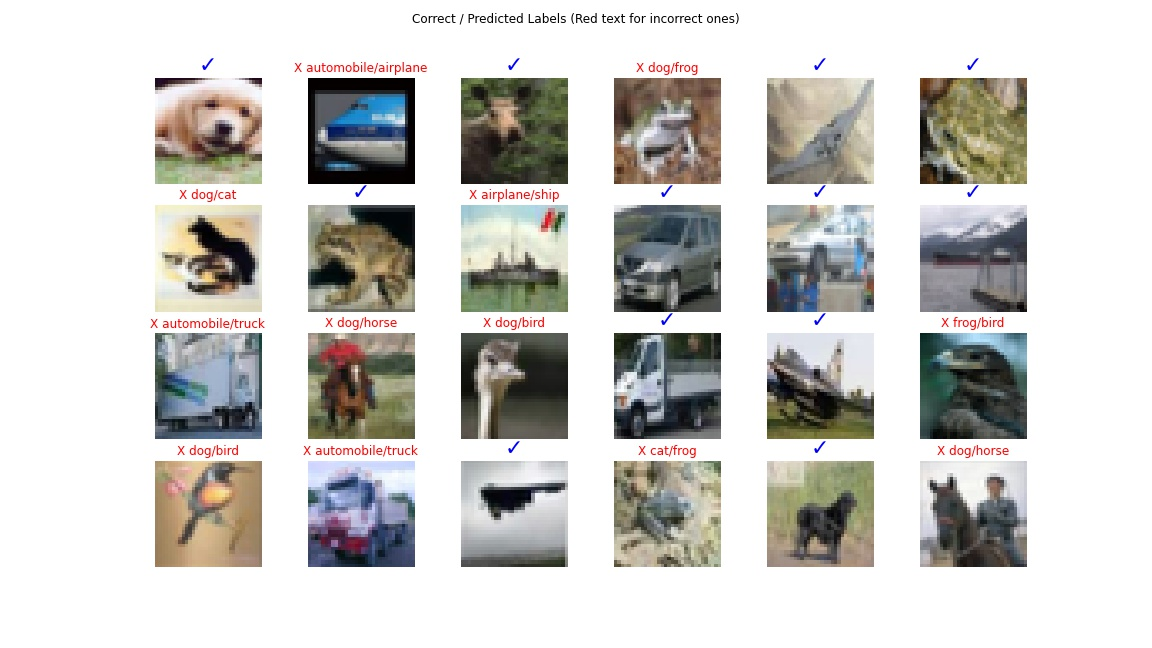

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread(RESULT_IMG_PATH, cv2.IMREAD_UNCHANGED)
cv2_imshow(img)